In [329]:
import numpy as np
from numpy import fft
import matplotlib.pyplot as plt
import matplotlib as mpl
from numpy import fft
from scipy.sparse import diags
import scipy.integrate as integrate
from mpl_toolkits.mplot3d import Axes3D
from scipy.fft import ifft
import time
from scipy.integrate import quad

N = 50
sigma = 0.1

dx = 0.01
dt = 0.1

a = 1
t_k = 1
D = 0.1

def gauss(x):
    return np.exp(- (x) ** 2 / sigma ** 2)

def gauss_zamik(x):
    return np.exp(- (x - 1/2) ** 2 / sigma ** 2)

def dirichlet_anal(funkcija, N, dt, dx):
    x = np.arange(0, a, dx)
    t = np.arange(0, t_k, dt)
    
    def koef(funkcija, N):
        koef_stevilo = []
        for n in range(N):
            lambda_n = np.pi * n / a
            result = 0
            for xi in np.arange(0, a, dx):
                result += funkcija(xi) * np.sin(lambda_n * xi) * dx
            koef_stevilo.append(result * 2 / a)
        return koef_stevilo

    koeficienti = koef(funkcija, N)

    def toplotna_anal(x, t):
        rezultat = 0
        for n in range(N):
            lambda_n = np.pi * n / a
            X = np.sin(lambda_n * x)
            T = np.exp(-D * lambda_n ** 2 * t)
            rezultat += X * T * koeficienti[n]
        return rezultat

    T = np.zeros((len(x), len(t)))
    for i in range(len(x)):
        for j in range(len(t)):
            T[i, j] = toplotna_anal(x[i], t[j])

    return x, t, T

def period_anal(funkcija, N, dt):
    x = np.arange(-a/2, a/2, dx)
    x_zamik = np.arange(0, a, dx)
    t = np.arange(0, t_k, dt)
    
    A0 = 0
    for xi in np.arange(-a/2, a/2, dx):
        A0 += funkcija(xi) * dx
    A0 /= a

    def An(funkcija, N):
        koef_stevilo = []
        for n in range(1, N):
            lambda_n = 2 * np.pi * n / a
            result = 0
            for xi in np.arange(-a/2, a/2, dx):
                result += funkcija(xi) * np.cos(lambda_n * xi) * dx
            koef_stevilo.append(result * 2 / a)
        return koef_stevilo

    def Bn(funkcija, N):
        koef_stevilo = []
        for n in range(1, N):
            lambda_n = 2 * np.pi * n / a
            result = 0
            for xi in np.arange(-a/2, a/2, dx):
                result += funkcija(xi) * np.sin(lambda_n * xi) * dx
            koef_stevilo.append(result * 2 / a)
        return koef_stevilo

    A = An(gauss, N)
    B = Bn(gauss, N)

    def toplotna_period(x, t):
        rezultat = A0
        for n in range(1, N):
            lambda_n = 2 * np.pi * n / a
            X = np.cos(lambda_n * x) * A[n-1] + np.sin(lambda_n * x) * B[n-1]
            T = np.exp(-D * lambda_n ** 2 * t)
            rezultat += X * T
        return rezultat

    T = np.zeros((len(x), len(t)))
    for i in range(len(x)):
        for j in range(len(t)):
            T[i, j] = toplotna_period(x[i], t[j])

    return x_zamik, t, T



In [330]:
def plot_3d_res(x, t, T, naslov):
    X, T_mreza = np.meshgrid(x, t)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, T_mreza, T.T, cmap='twilight_shifted')
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('Temperature T(x,t)')
    ax.view_init(elev=30, azim=25)
    ax.set_title(naslov)
    plt.show()

def plot_2d_res(x, t, T, naslov, num_points=10):
    plt.figure()
    casovne_tocke = np.linspace(0, len(t)-1, num_points, dtype=int)
    
    for j in casovne_tocke:
        plt.plot(x, T[:, j], label=f't = {t[j]:.2f}')
    
    plt.xlabel('x')
    plt.ylabel('Temperatura T(x,t)')
    plt.title(naslov)
    plt.legend()
    plt.show()
    



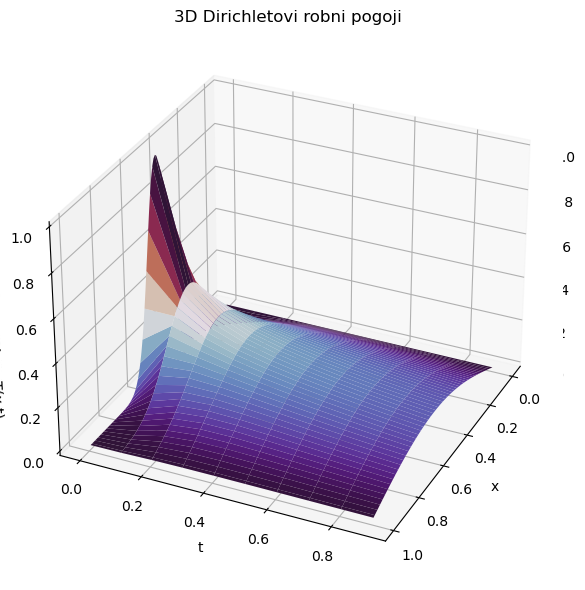

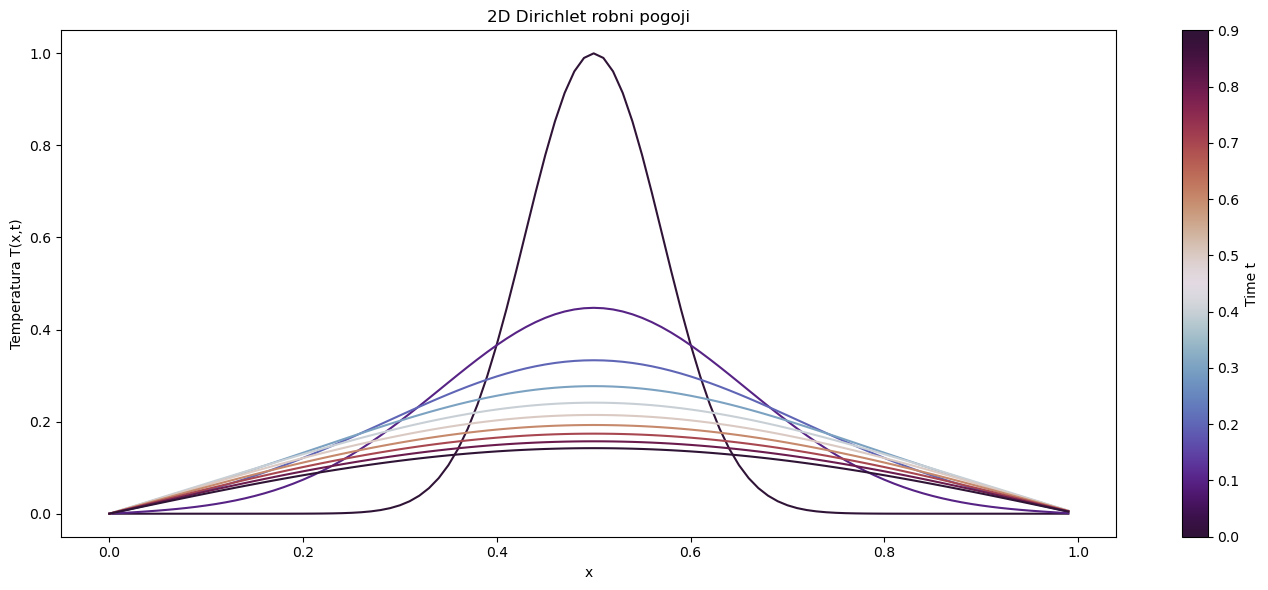

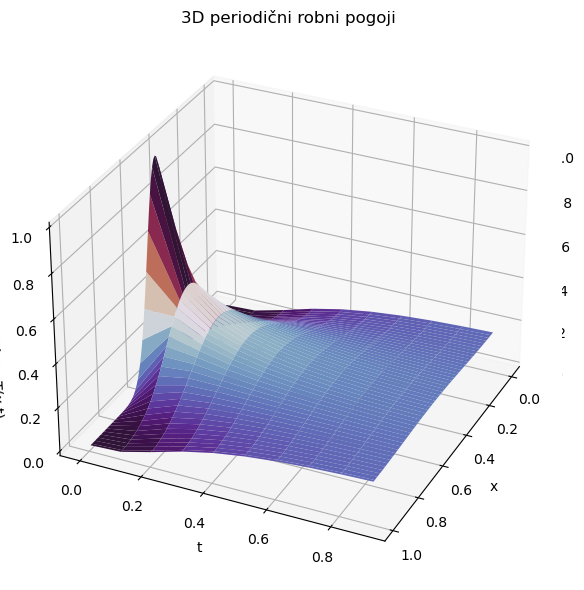

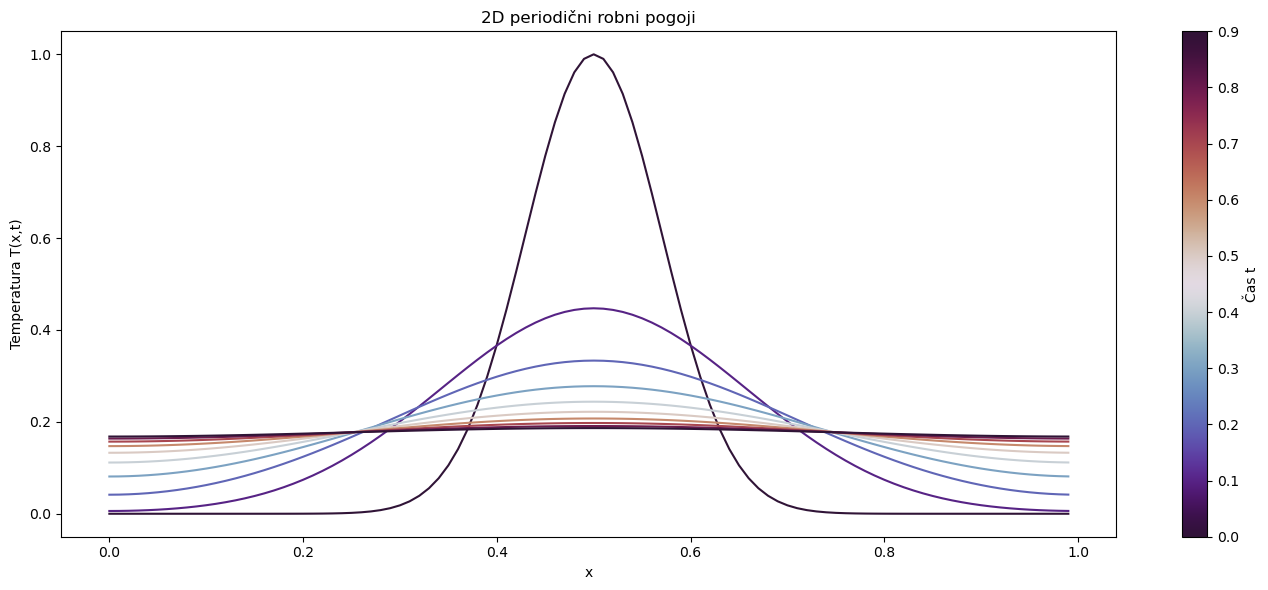

In [331]:
x_dirichlet, t_dirichlet, T_dirichlet = dirichlet_anal(gauss_zamik, N, dt, dx)
x_period, t_period, T_period = period_anal(gauss, N, dt)

def plot_res_dirichlet(x_dirichlet, t_dirichlet, T_dirichlet):
    fig_3d, ax_3d = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(14, 6))
    ax_3d = fig_3d.add_subplot(111, projection='3d')
    X, T = np.meshgrid(x_dirichlet, t_dirichlet)
    ax_3d.plot_surface(X, T, T_dirichlet.T, cmap='twilight_shifted')
    ax_3d.set_xlabel('x')
    ax_3d.set_ylabel('t')
    ax_3d.set_zlabel('Temperatura T(x,t)')
    ax_3d.view_init(elev=30, azim=25)
    ax_3d.set_title('3D Dirichletovi robni pogoji')
    plt.tight_layout()
    plt.savefig('dirichlet_3d_plot.png')
    plt.show()

    fig_2d, ax_2d = plt.subplots(figsize=(14, 6))
    n_dirichlet = len(t_dirichlet)
    colors_dirichlet = plt.cm.twilight_shifted(np.linspace(0, 1, n_dirichlet))

    for j in range(n_dirichlet):
        ax_2d.plot(x_dirichlet, T_dirichlet[:, j], color=colors_dirichlet[j])

    norm_dirichlet = mpl.colors.Normalize(vmin=t_dirichlet[0], vmax=t_dirichlet[-1])
    smap_dirichlet = mpl.cm.ScalarMappable(norm=norm_dirichlet, cmap='twilight_shifted')
    fig_2d.colorbar(smap_dirichlet, ax=ax_2d, label='Time t')
    ax_2d.set_xlabel('x')
    ax_2d.set_ylabel('Temperatura T(x,t)')
    ax_2d.set_title('2D Dirichlet robni pogoji')
    plt.tight_layout()
    plt.savefig('dirichlet_2d_plot.png')
    plt.show()

plot_res_dirichlet(x_dirichlet, t_dirichlet, T_dirichlet)

def plot_res_period(x_period, t_period, T_period):
    fig_3d, ax_3d = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(14, 6))
    ax_3d = fig_3d.add_subplot(111, projection='3d')
    X, T = np.meshgrid(x_period, t_period)
    ax_3d.plot_surface(X, T, T_period.T, cmap='twilight_shifted')
    ax_3d.set_xlabel('x')
    ax_3d.set_ylabel('t')
    ax_3d.set_zlabel('Temperatura T(x,t)')
    ax_3d.view_init(elev=30, azim=25)
    ax_3d.set_title('3D periodični robni pogoji')
    plt.tight_layout()
    plt.savefig('period_3d_plot.png')
    plt.show()

    fig_2d, ax_2d = plt.subplots(figsize=(14, 6))
    n_period = len(t_period)
    colors_period = plt.cm.twilight_shifted(np.linspace(0, 1, n_period))

    for j in range(n_period):
        ax_2d.plot(x_period, T_period[:, j], color=colors_period[j])

    norm_period = mpl.colors.Normalize(vmin=t_period[0], vmax=t_period[-1])
    smap_period = mpl.cm.ScalarMappable(norm=norm_period, cmap='twilight_shifted')
    fig_2d.colorbar(smap_period, ax=ax_2d, label='Čas t')
    ax_2d.set_xlabel('x')
    ax_2d.set_ylabel('Temperatura T(x,t)')
    ax_2d.set_title('2D periodični robni pogoji')
    plt.tight_layout()
    plt.savefig('period_2d_plot.png')
    plt.show()

plot_res_period(x_period, t_period, T_period)



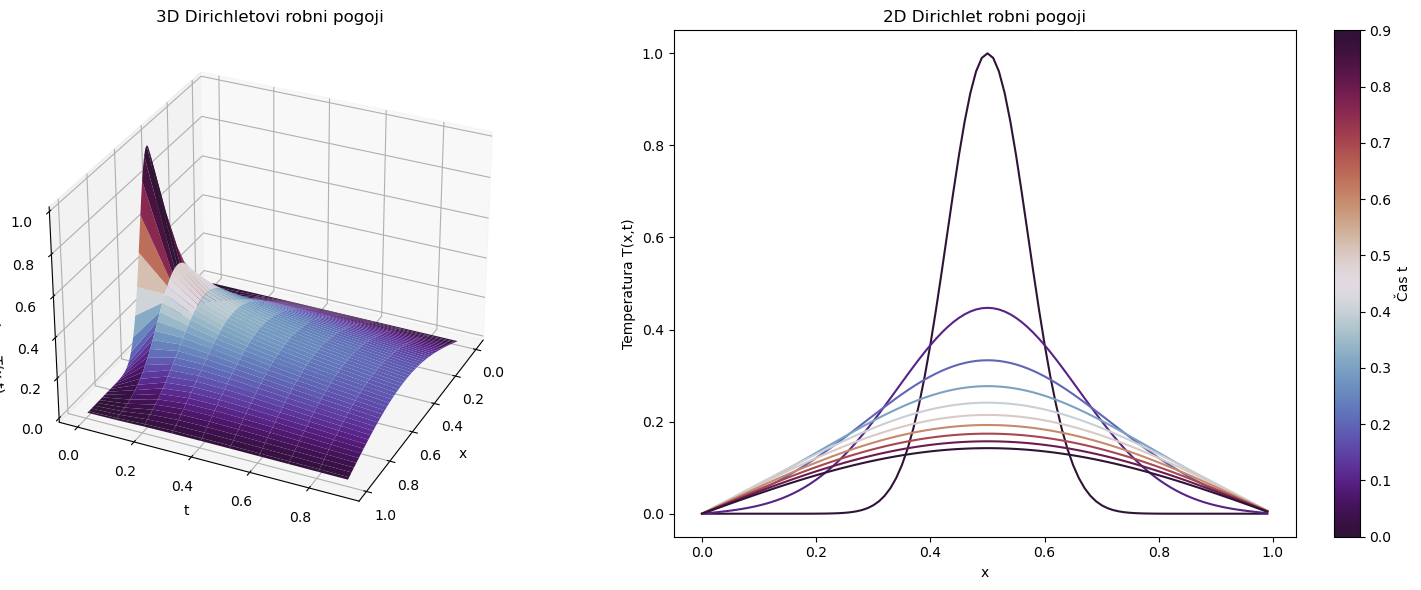

<Figure size 640x480 with 0 Axes>

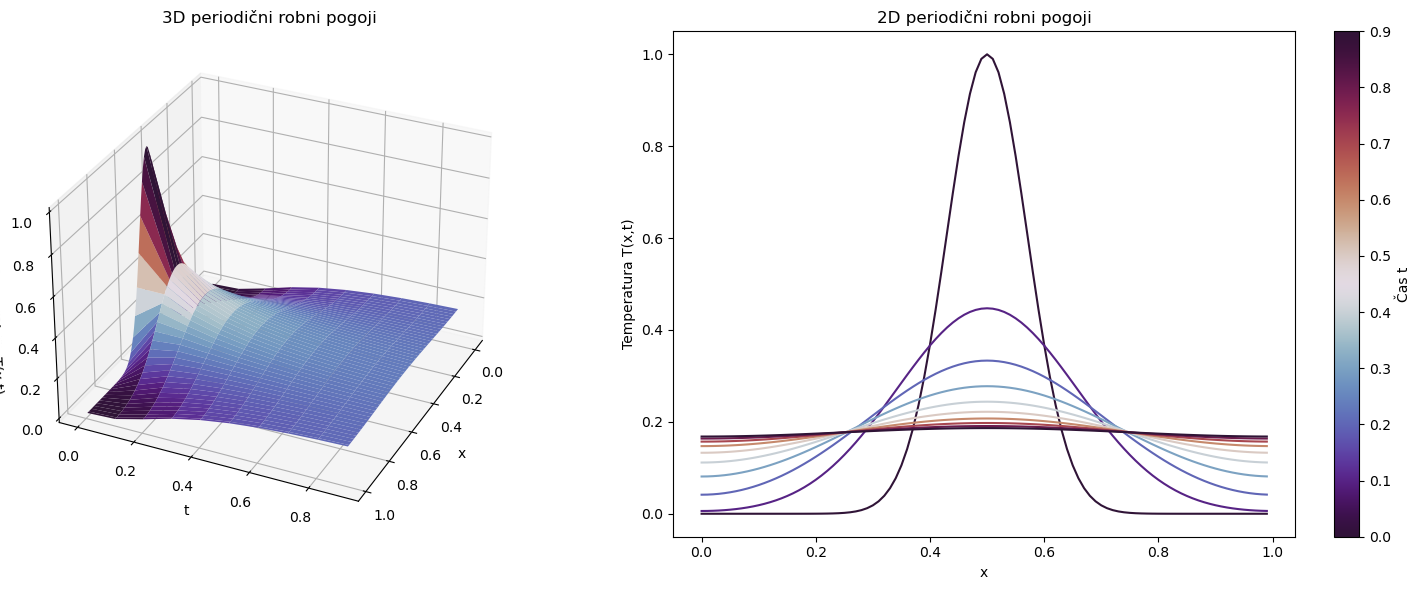

<Figure size 640x480 with 0 Axes>

In [332]:
def plot_res(x, t, T, naslov_3d, naslov_2d, datoteka_3d, datoteka_2d):
    fig = plt.figure(figsize=(16, 6))

    ax_3d = fig.add_subplot(121, projection='3d')
    X, T_grid = np.meshgrid(x, t)
    ax_3d.plot_surface(X, T_grid, T.T, cmap='twilight_shifted')
    ax_3d.set_xlabel('x')
    ax_3d.set_ylabel('t')
    ax_3d.set_zlabel('Temperatura T(x,t)')
    ax_3d.view_init(elev=30, azim=25)
    ax_3d.set_title(naslov_3d)

    ax_2d = fig.add_subplot(122)
    n_tock = len(t)
    barve = plt.cm.twilight_shifted(np.linspace(0, 1, n_tock))
    for j in range(n_tock):
        ax_2d.plot(x, T[:, j], color=barve[j])

    norm = mpl.colors.Normalize(vmin=t[0], vmax=t[-1])
    smap = mpl.cm.ScalarMappable(norm=norm, cmap='twilight_shifted')
    fig.colorbar(smap, ax=ax_2d, label='Čas t')
    ax_2d.set_xlabel('x')
    ax_2d.set_ylabel('Temperatura T(x,t)')
    ax_2d.set_title(naslov_2d)
    
    plt.tight_layout()
    plt.savefig(datoteka_3d)
    plt.show()

    plt.tight_layout()
    plt.savefig(datoteka_2d)
    plt.show()

plot_res(
    x_dirichlet, 
    t_dirichlet, 
    T_dirichlet, 
    '3D Dirichletovi robni pogoji', 
    '2D Dirichlet robni pogoji', 
    'dirichlet_3d_plot.png', 
    'dirichlet_2d_plot.png'
)

plot_res(
    x_period, 
    t_period, 
    T_period, 
    '3D periodični robni pogoji', 
    '2D periodični robni pogoji', 
    'period_3d_plot.png', 
    'period_2d_plot.png'
)


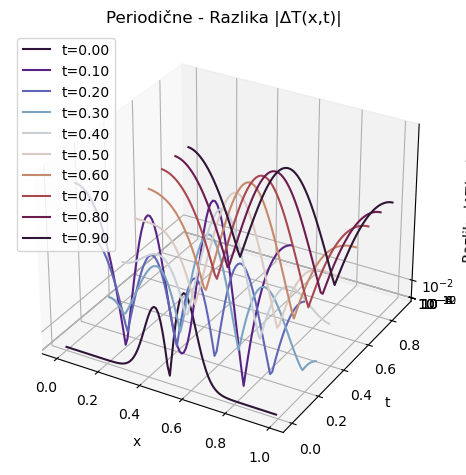

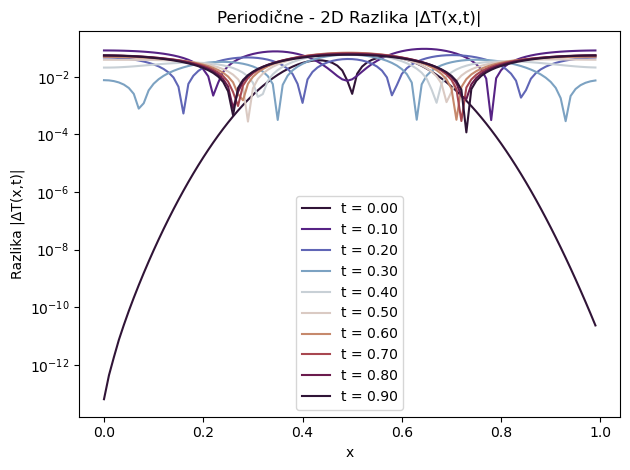

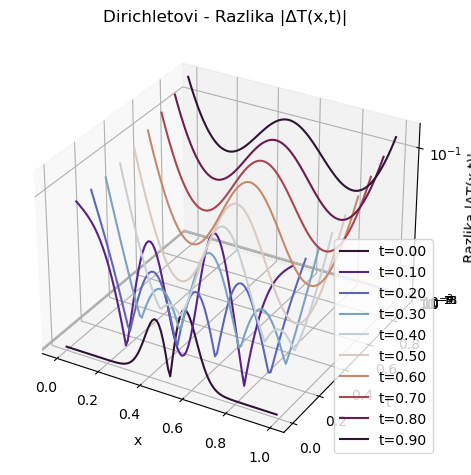

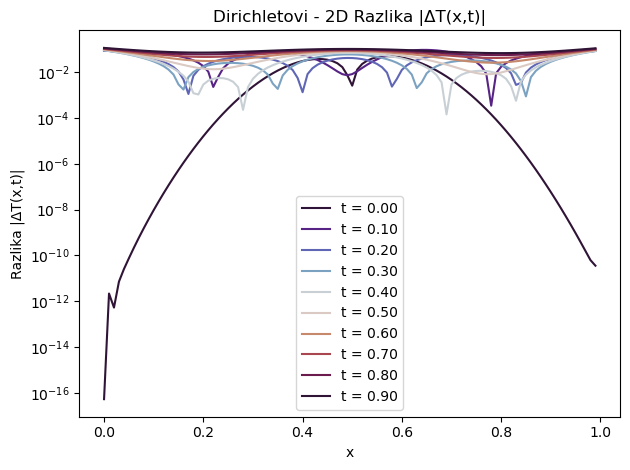

In [333]:
def period_gauss(x):
    return amp * np.exp(-(x - nu)**2 / sig**2)

def dirichlet_gauss(x):
    arr = amp * np.exp(-(x - nu)**2 / sig**2)
    arr[0], arr[-1] = [0, 0]
    arr = np.append(arr, -arr[:0:-1])
    return arr[:len(x)]


def plot_3d_difference_steps(x, t, T_diff, naslov, casovne_indekse, merilo='linear'):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    colors = plt.cm.twilight_shifted(np.linspace(0, 1, len(casovne_indekse)))
    for idx, i in enumerate(casovne_indekse):
        ax.plot(x, np.full_like(x, t[i % len(t)]), T_diff[:, i], label=f't={t[i % len(t)]:.2f}', color=colors[idx])
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('Razlika |ΔT(x,t)|')
    ax.set_title(naslov)
    if merilo == 'log':
        ax.set_zscale('log')
    ax.legend()
    plt.tight_layout()
    plt.savefig(f'{naslov.replace(" ", "_")}_3d.png')
    plt.show()

def plot_2d_difference(x, T_diff, t, naslov, merilo='linear'):
    plt.figure()
    casovne_tocke = np.linspace(0, len(t) - 1, 10, dtype=int)
    colors = plt.cm.twilight_shifted(np.linspace(0, 1, len(casovne_tocke)))
    for idx, j in enumerate(casovne_tocke):
        plt.plot(x, T_diff[:, j], label=f't = {t[j]:.2f}', color=colors[idx])
    plt.xlabel('x')
    plt.ylabel('Razlika |ΔT(x,t)|')
    plt.title(naslov)
    if merilo == 'log':
        plt.yscale('log')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{naslov.replace(" ", "_")}_2d.png')
    plt.show()

x_period, t_period, T_anal_period = period_anal(gauss, N, dt)
x2, t2, T2_period = solve(period_gauss, 2 * N, dt)

T_diff_period = np.abs(T_anal_period - T2_period)

plot_3d_difference_steps(x_period, t_period, T_diff_period, 'Periodične - Razlika |ΔT(x,t)|', np.linspace(0, len(t_period) - 1, 10, dtype=int), merilo='log')

plot_2d_difference(x_period, T_diff_period, t_period, 'Periodične - 2D Razlika |ΔT(x,t)|', merilo='log')

x_dirichlet, t_dirichlet, T_anal_dirichlet = dirichlet_anal(gauss_zamik, N, dt, dx)
x2, t2, T2_dirichlet = solve(dirichlet_gauss, 2 * N, dt)

T_diff_dirichlet = np.abs(T_anal_dirichlet - T2_dirichlet)

plot_3d_difference_steps(x_dirichlet, t_dirichlet, T_diff_dirichlet, 'Dirichletovi - Razlika |ΔT(x,t)|', np.linspace(0, len(t_dirichlet) - 1, 10, dtype=int), merilo='log')

plot_2d_difference(x_dirichlet, T_diff_dirichlet, t_dirichlet, 'Dirichletovi - 2D Razlika |ΔT(x,t)|', merilo='log')


In [334]:
#def b_splines(dx, k, x0):
#    if(x0 <= dx*(k-2)):
#        return 0.
#    elif(x0 <= dx*(k-1)):
#        return (x0 - (k-2)*dx)**3. / (6. * dx**3.)
#    elif(x0 <= dx*k):
#        return 1 / 6. + (x0 - dx*(k-1)) / (2. * dx) + (x0 - dx*(k-1))**2. / (2. * dx**2.) -\
#               (x0 - dx*(k-1))**3. / (2. * dx**3.)
#    elif(x0 <= dx*(k+1)):
#        return 1 / 6. - (x0 - dx*(k+1)) / (2. * dx) + (x0 - dx*(k+1))**2. / (2. * dx**2.) +\
#               (x0 - dx*(k+1))**3. / (2. * dx**3.)
#    elif(x0 <= dx*(k+2)):
#        return -(x0 - dx*(k+2))**3. / (6. * dx**3.)
#    else:
#        return 0.
#
#def kolokacijska(N):
#    a = 1
#    t_f = 1
#    D = 0.1
#
#    dx = a / N
#    dt = 0.1
#
#    x = np.arange(0,a,dx)
#    t = np.arange(0,t_f,dt)
#
#    A = diags([1, 4, 1], [-1, 0, 1], shape=(N, N)).toarray()
#    B = diags([1, -2, 1], [-1, 0, 1], shape=(N, N)).toarray()
#    B *= 6 * D / dx ** 2
#
#    sigma = 0.1
#    def func(x):
#        return np.exp(- (x-a/2) ** 2 / sigma ** 2)
#
#    f = func(x)
#    c0 = np.zeros(N+2)
#    c0 = np.linalg.solve(A, 6 * f)
#    vektorji = [c0]
#
#    for i in range(N+1):
#        C_minus = A - B * dt / 2 
#        C_plus = A + B * dt / 2
#        vektorji.append(np.linalg.solve(C_minus, np.matmul(C_plus, vektorji[-1])))
#    vektorji = np.array(vektorji)
#
#    T = np.zeros((int(a / dx), int(t_f / dt)))
#
#    for i in range(N):
#        for j in range(1,len(t)):
#            vsota = 0
#            for k in range(N+2):
#                vsota += vektorji[k][i] * b_splines(dx, k - 1, x[j])
#            T[i,j] = vsota
#    T[:,0] = f
#    return x, t, T
#
#def T_analytical(x, t, D, sigma, nu):
#    if t == 0:
#        return np.zeros_like(x)
#    return (1 / np.sqrt(4 * np.pi * D * t)) * np.exp(- (x - nu) ** 2 / (4 * D * t))
#
## Parameters
#sigma = 0.1
#nu = 0.5
#D = 0.2
#N = 50  # Number of grid points
#
## Run the collocation method
#x, t, T = kolokacijska(N)
#
## Compute the analytical solution
#T_anal = np.zeros((len(x), len(t)))
#for i, time in enumerate(t):
#    T_anal[:, i] = T_analytical(x, time, D, sigma, nu)
#
## Plot the difference between numerical and analytical solutions
#dT = np.abs(T - T_anal)
#plt.figure()
#time_points = [0, len(t)//4, len(t)//2, len(t)-1]  # Select 4 time points
#for j in time_points:
#    plt.plot(x, dT[:, j], label=f't = {t[j]:.2f}')
#plt.xlabel('x')
#plt.ylabel('Difference |ΔT(x,t)|')
#plt.title('Difference Between Analytical and Numerical Solutions')
#plt.legend()
#plt.show()
#
## 1. 3D Surface Plot of the Temperature Distribution
#X, Y = np.meshgrid(x, t)
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(X, Y, T.T, cmap='viridis')
#ax.set_xlabel('x')
#ax.set_ylabel('t')
#ax.set_zlabel('T(x,t)')
#ax.set_title('3D Surface Plot of Temperature Distribution')
#plt.show()
#
## 2. 2D Plot of Temperature Profiles at Different Time Points
#plt.figure()
#time_points = [0, len(t)//4, len(t)//2, len(t)-1]  # Select 4 time points
#for j in time_points:
#    plt.plot(x, T[:, j], label=f't = {t[j]:.2f}')
#plt.xlabel('x')
#plt.ylabel('T(x,t)')
#plt.title('Temperature Profiles at Different Time Points')
#plt.legend()
#plt.show()
#
## 3. 2D Plot of the Difference Between Analytical and Numerical Solutions
#plt.figure()
#for j in time_points:
#    plt.plot(x, dT[:, j], label=f't = {t[j]:.2f}')
#plt.xlabel('x')
#plt.ylabel('Difference |ΔT(x,t)|')
#plt.title('Difference Between Analytical and Numerical Solutions')
#plt.legend()
#plt.show()
#
#

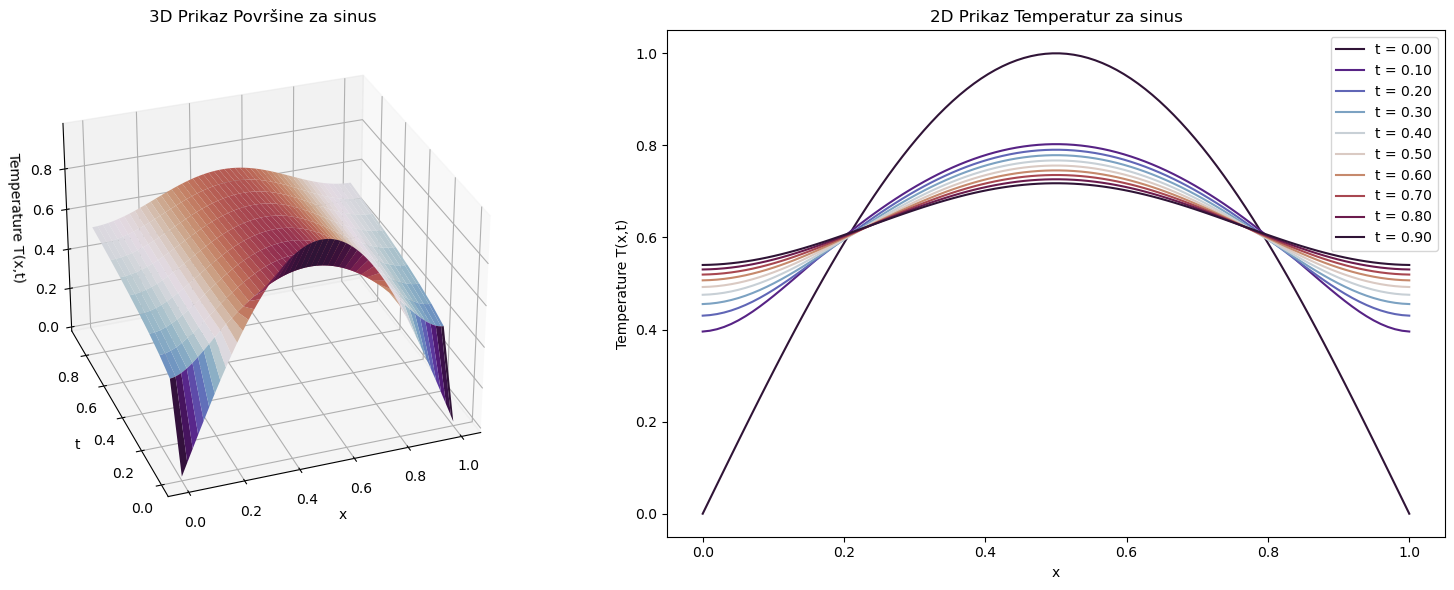

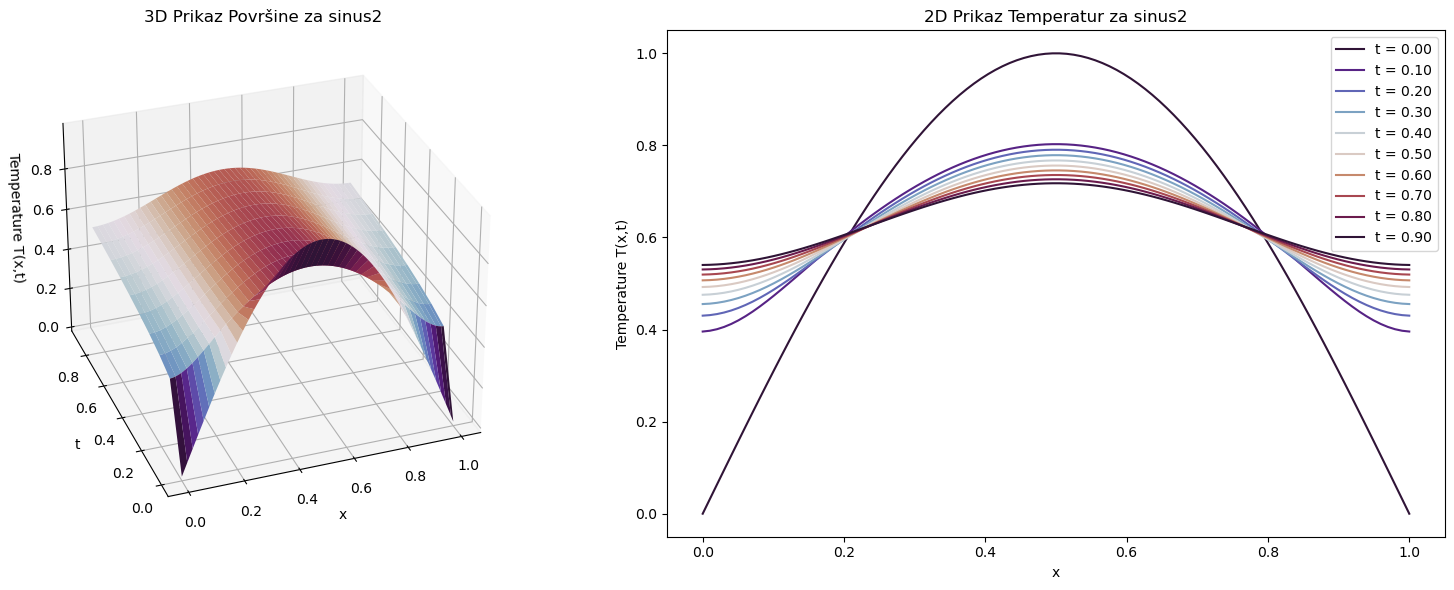

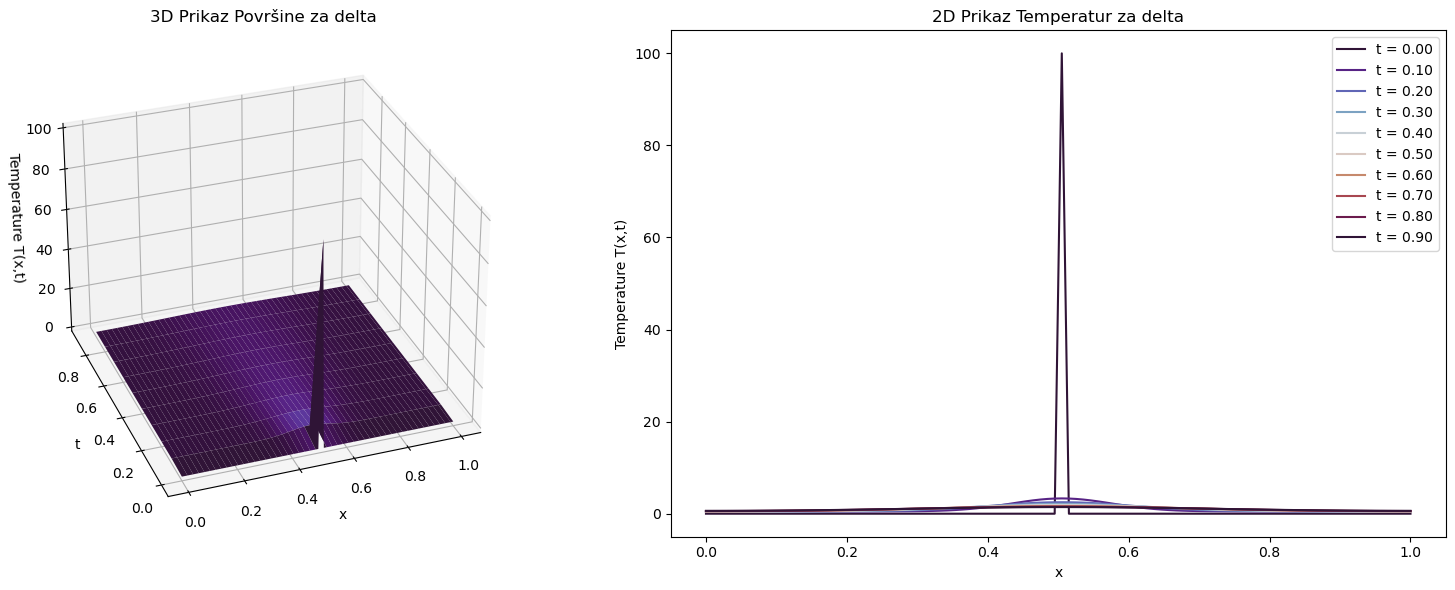

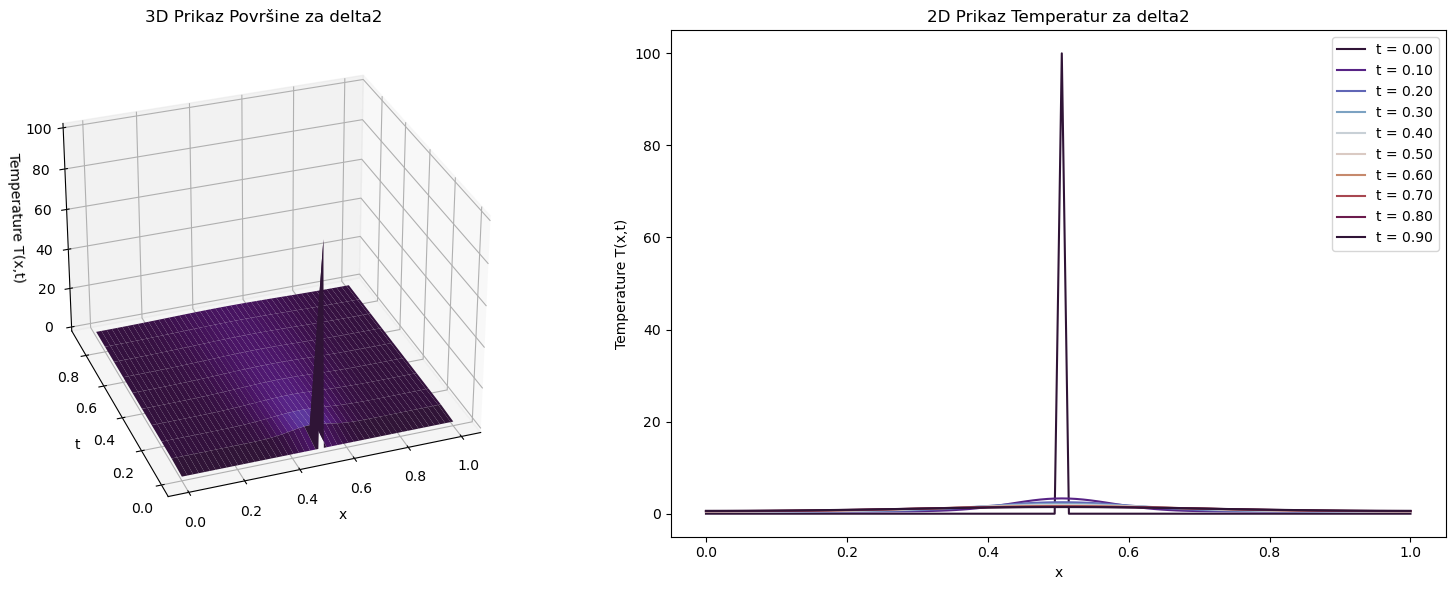

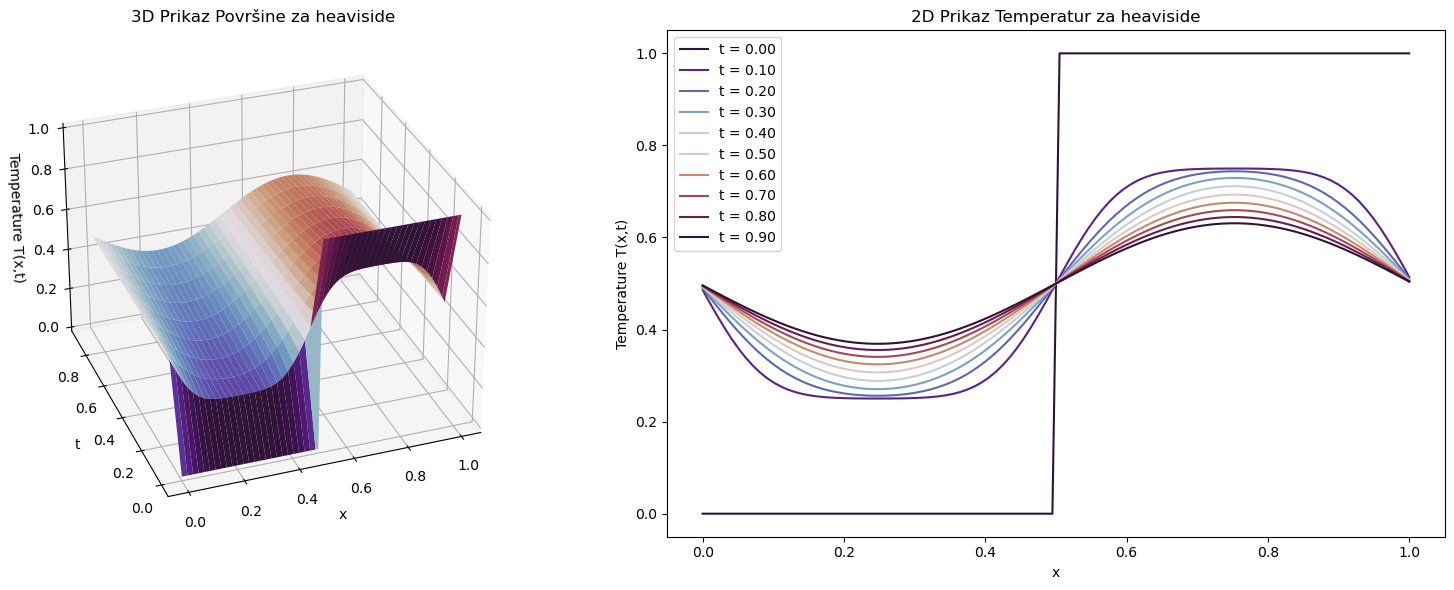

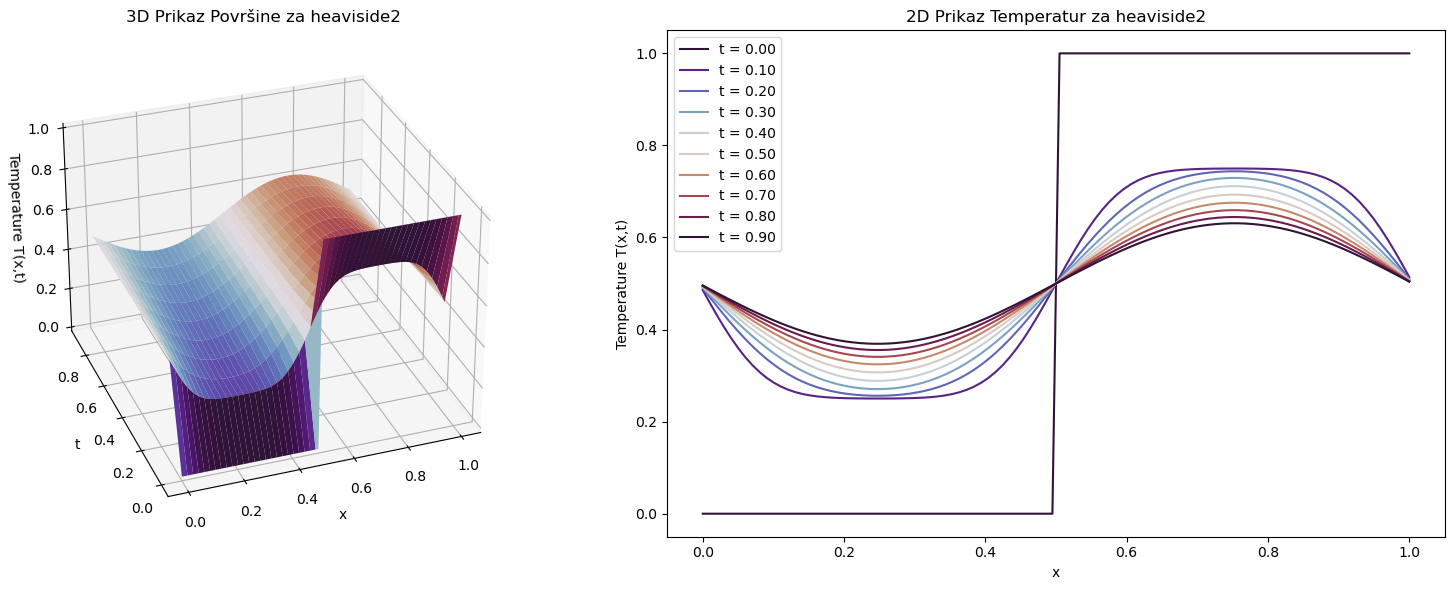

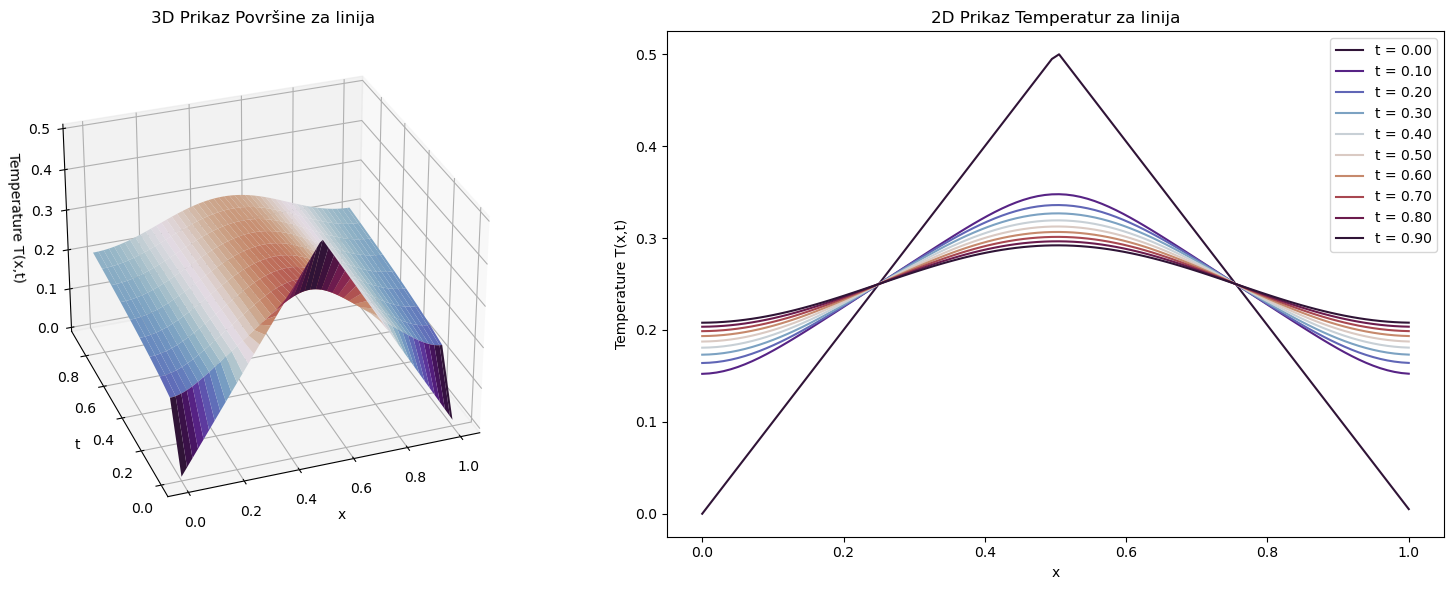

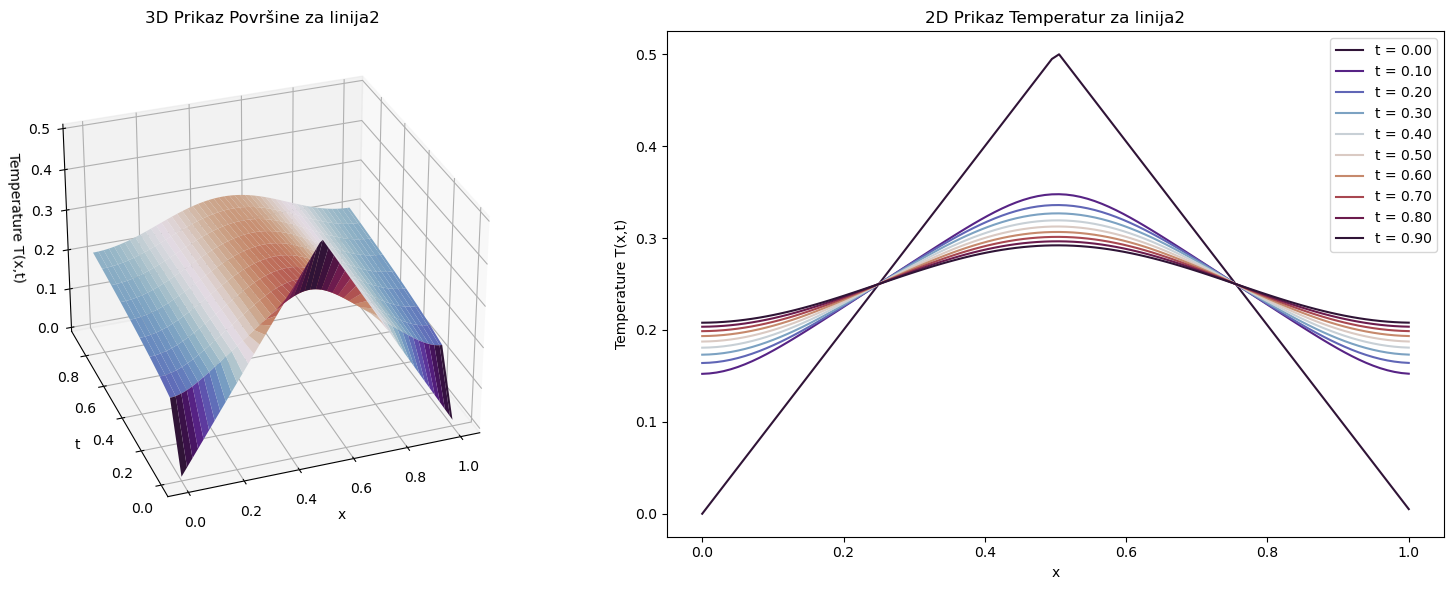

In [335]:
from scipy.fft import ifft

a = 1
D = 0.1
N = 100
dt = 0.1
sigma = 0.1

def resitev(func, N, dt):
    x = np.linspace(0, 1, N)
    t = np.arange(0, 1, dt)
    T = np.zeros((N, len(t)))

    f_x = func(x)
    if len(f_x) != N:
        raise ValueError(f"Izhod funkcije ima dolžino {len(f_x)}, vendar je pričakovano {N}.")

    for i in range(len(t)):
        T[:, i] = np.fft.ifft(np.fft.fft(f_x) * np.exp(-D * (np.pi * np.arange(N))**2 * t[i])).real

    return x, t, T

def sinus(x):
    return np.sin(np.pi * x / a)

def sinus2(x):
    arr = np.sin(np.pi * x / a)
    arr[0], arr[-1] = [0, 0]
    arr = np.append(arr, -arr[:0:-1])
    return arr[:len(x)]

def delta(x):
    arr = np.zeros(len(x))
    arr[len(x) // 2] = len(x)
    return arr

def delta2(x):
    arr = np.zeros(len(x))
    arr[len(x) // 2] = len(x)
    arr = np.append(arr, -arr[:0:-1])
    return arr[:len(x)]

def heaviside(x):
    return np.heaviside(np.linspace(-a / 2, a / 2, len(x)), 0.5)

def heaviside2(x):
    arr = np.heaviside(np.linspace(-a / 2, a / 2, len(x)), 0.5)
    arr = np.append(arr, -arr[:0:-1])
    return arr[:len(x)]

def linija(x):
    return np.append(x[:len(x) // 2], 1 / 2 * np.ones(len(x) // 2) - x[:len(x) // 2])

def linija2(x):
    arr = np.append(x[:len(x) // 2], 1 / 2 * np.ones(len(x) // 2) - x[:len(x) // 2])
    arr = np.append(arr, -arr[:0:-1])
    return arr[:len(x)]

def izris_2d_3d_par(x, t, T, naslov_3d, naslov_2d, ime_funkcije, num_points=10):
    fig = plt.figure(figsize=(16, 6))

    # 3D Plot
    ax_3d = fig.add_subplot(121, projection='3d')
    X, T_mreza = np.meshgrid(x, t)
    ax_3d.plot_surface(X, T_mreza, T.T, cmap='twilight_shifted')
    ax_3d.set_xlabel('x')
    ax_3d.set_ylabel('t')
    ax_3d.set_zlabel('Temperature T(x,t)')
    ax_3d.view_init(elev=30, azim=-110)
    ax_3d.set_title(naslov_3d)

    # 2D Plot
    ax_2d = fig.add_subplot(122)
    casovne_tocke = np.linspace(0, len(t) - 1, num_points, dtype=int)
    barve = plt.cm.twilight_shifted(np.linspace(0, 1, num_points))

    for idx, j in enumerate(casovne_tocke):
        ax_2d.plot(x, T[:, j], label=f't = {t[j]:.2f}', color=barve[idx])

    ax_2d.set_xlabel('x')
    ax_2d.set_ylabel('Temperature T(x,t)')
    ax_2d.set_title(naslov_2d)
    ax_2d.legend()

    plt.tight_layout()
    plt.savefig(f'{ime_funkcije}_solution_pair.png')
    plt.show()

funkcije = [sinus, sinus2, delta, delta2, heaviside, heaviside2, linija, linija2]

for funkcija in funkcije:
    x, t, T = resitev(funkcija, N, dt)

    x = np.real(x)
    t = np.real(t)
    T = np.real(T)

    izris_2d_3d_par(
        x, t, T, 
        f'3D Prikaz Površine za {funkcija.__name__}', 
        f'2D Prikaz Temperatur za {funkcija.__name__}', 
        funkcija.__name__
    )
